<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [131]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy.xlsx'
#file_path = '/content/drive/MyDrive/WATFORD FC/Datos GPS/datos_finales_tommy2.xlsx'
#file_path = 'datos_finales_tommy.xlsx'
file_path = 'datos_finales_tommy2.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
print(df.head())

        DATE Microcycle  Injury preseason-season      TD    HSR  +25 Km/h  \
0 2021-08-11        M-3       0           SEASON  7423.0  426.0        20   
1 2021-08-12        M-2       0           SEASON  1268.0    0.0         0   
2 2021-08-13        M-1       0           SEASON  4135.0  112.0         2   
3 2021-08-15        M+1       0           SEASON  6379.0   86.0         0   
4 2021-08-17        M-4       0           SEASON  6287.0  209.0         9   

    ACC   DEC  PlayerID  ...   TD_MSWR  HSR_ACWR  HSR_MSWR  +25 Km/h_ACWR  \
0  52.0  38.0     23085  ...  5.217107  1.000000  1.923701       1.000000   
1  11.0   5.0     23085  ...  1.508831  1.000000  0.974045       1.000000   
2  47.0  20.0     23085  ...  1.771797  1.000000  1.017839       1.000000   
3  49.0  48.0     23085  ...  1.405105  1.000000  0.855593       1.000000   
4  62.0  44.0     23085  ...  1.140354  0.924272  0.762941       0.545055   

   +25 Km/h_MSWR  ACC_ACWR  ACC_MSWR  DEC_ACWR   DEC_MSWR  Injury_7_day  


Chequear desbalanceo de clases

In [42]:
print("No Lesión: " + str(df[df["Injury_7_day"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury_7_day"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury_7_day'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 7055
Lesión: 268
Porcentaje de lesionados en el dataset: 3.66%


# Initialize metrics

In [109]:
metrics = ['TD', 'HSR',
       '+25 Km/h', 'ACC', 'DEC', 'Sprints', '% Max Speed']

# Correlation of variables

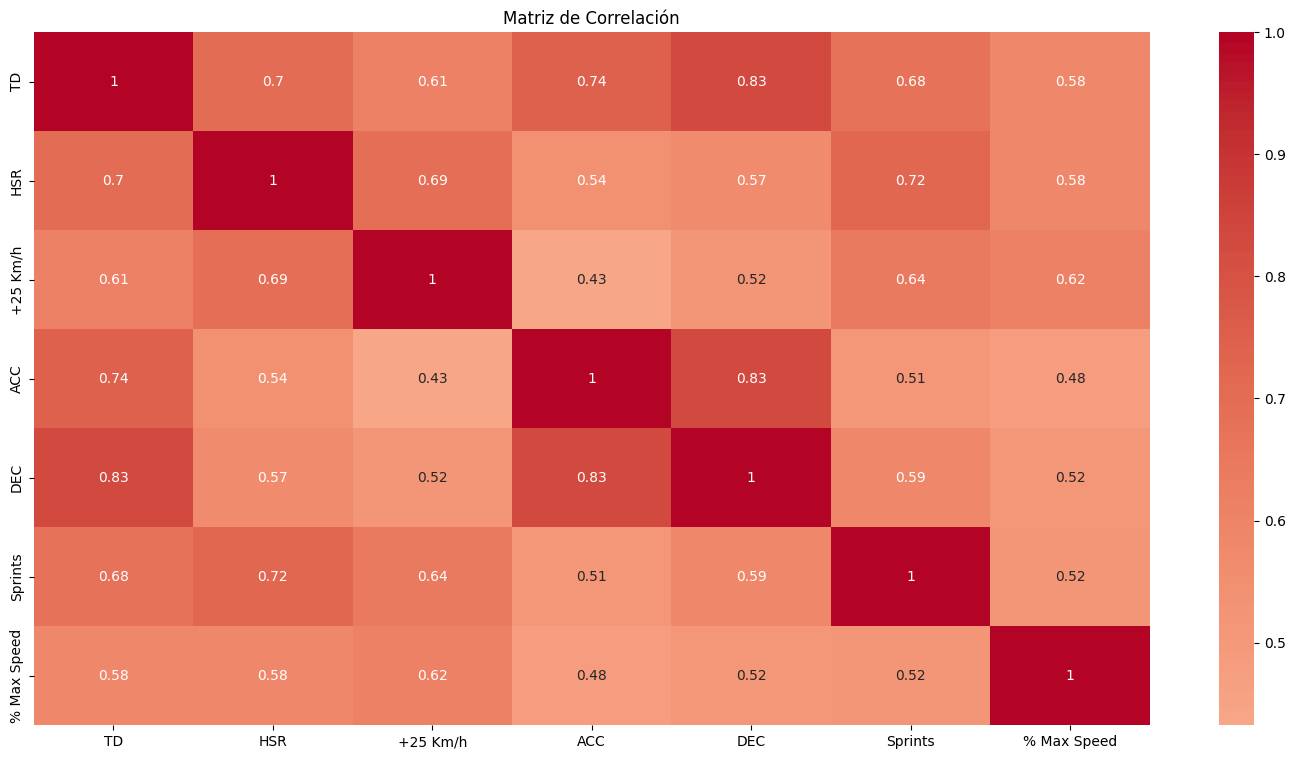

In [113]:
# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [114]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

      Variable        VIF
0        const  68.786842
1           TD   4.574959
2          HSR   2.948752
3     +25 Km/h   2.408087
4          ACC   3.431651
5          DEC   4.917893
6      Sprints   2.527502
7  % Max Speed   1.867356


# ML Modelos

## Separate data into X, y and player_ids

In [138]:
# metrics = ['TD', 'HSR',
#        '+25 Km/h', 'ACC', 'DEC', 'Sprints','% Max Speed', 'TD_Rel', 'HSR_Rel', '+25 Km/h_Rel', 'ACC_Rel',
#        'DEC_Rel', 'TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
#        '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
#        'Sprints-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR',
#        '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']

metrics = ['TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7',
       '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7',
       'Sprints-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR',
       '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']

print(len(metrics))

19


In [139]:
player_ids = df['PlayerID']
X = df[metrics]
y = df['Injury_7_day']

## Feature Engineering

**Feature Selection**

Removes features with low variance

In [140]:
# Initialize VarianceThreshold with a threshold
vt = VarianceThreshold(threshold=0.01)  # Removes features with variance < 0.01

# Apply VarianceThreshold to the entire dataset (X)
X_reduced = vt.fit_transform(X)  # Retains only high-variance features

# Get selected feature names (if X is a DataFrame)
removed_features = X.columns[~vt.get_support()]
print("Removed Features:", removed_features)

Removed Features: Index([], dtype='object')


Based on the response , there is no columns that need to be removed

## SMOTE Technique

In [141]:
# Split the data into training and test sets (test set remains untouched)
X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.2, random_state=42, stratify=y)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury_7_day
0    5644
1    5644
Name: count, dtype: int64
Injury_7_day
0    5644
1    5644
Name: count, dtype: int64


## XGBoost Model

Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

Use GridSearch to find the best hyperparameters

In [142]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 10,              # L1 regularization
    'gamma': 10,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=19,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

Selected Features (RFE): ['TD-7', 'TD_EWMA-7', 'HSR-7', 'HSR_EWMA-7', '+25 Km/h-7', '+25 Km/h_EWMA-7', 'ACC-7', 'ACC_EWMA-7', 'DEC-7', 'DEC_EWMA-7', 'Sprints-7', 'TD_ACWR', 'TD_MSWR', 'HSR_ACWR', 'HSR_MSWR', '+25 Km/h_ACWR', '+25 Km/h_MSWR', 'ACC_ACWR', 'DEC_ACWR']
Number of features selected: 19


In [148]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'subsample': 0.8,
}

# Parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.07,0.09, 0.11, 0.13, 0.15],  # Explore smaller learning rates
    'max_depth': [5,7,9,11],             # Test broader depth values
    'n_estimators': [600, 800, 1000, 1200],     # Include larger estimators
    'scale_pos_weight': [9, 13, 15, 19, 21],    # Class imbalance adjustment
    'alpha': [5,10],  # L1 regularization
    'gamma': [5,10],  # Minimum loss reduction
}

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 0.9905
Best Parameters: {'alpha': 5, 'gamma': 5, 'learning_rate': 0.07, 'max_depth': 9, 'n_estimators': 1200, 'scale_pos_weight': 21}


## Train the model with the best parameters and add early stopping

Final Test ROC-AUC: 0.7626
Accuracy: 0.7078
Precision: 0.0844
Recall: 0.7037
F1 Score: 0.1508
Confusion Matrix:
[[999 412]
 [ 16  38]]


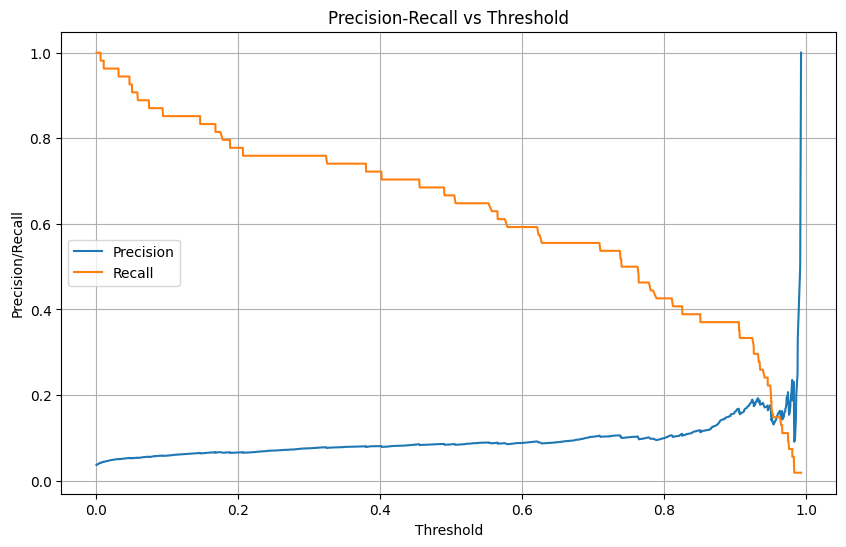

In [149]:
# Train the final model
final_model = XGBClassifier(
    **base_params_xgboost,
    **best_params,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.45
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot precision vs recall for different thresholds

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


## Transform test data

In [145]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
player_ids_test = player_ids_test.reset_index(drop=True)

In [146]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': player_ids_test,  # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', 'HSR-7', '+25 Km/h-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics



Test ROC-AUC: 0.7545


In [147]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)